# Project Objective

# The goal of this project is to analyze historical Apple (AAPL) stock prices and build a time-series prediction model using LSTM (Long Short-Term Memory) networks to forecast future stock prices.

In [1]:
import seaborn as sns
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler


# Data Collection

In [2]:
import yfinance as yf
data = yf.download('AAPL', start='2014-01-01', end='2024-12-31')

C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_24732\1338481883.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2014-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.173325,17.294410,17.138862,17.252496,234684800
2014-01-03,16.796101,17.191024,16.779024,17.164946,392467600
2014-01-06,16.887693,16.976799,16.566972,16.686506,412610800
2014-01-07,16.766924,16.950725,16.701103,16.899807,317209200
2014-01-08,16.873102,16.938301,16.725006,16.728730,258529600


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2767 entries, 2014-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2767 non-null   float64
 1   (High, AAPL)    2767 non-null   float64
 2   (Low, AAPL)     2767 non-null   float64
 3   (Open, AAPL)    2767 non-null   float64
 4   (Volume, AAPL)  2767 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 129.7 KB


In [5]:
data.shape


(2767, 5)

# Exploratory Data Analysis (EDA)

# Trend Analysis: Plotted closing prices over time.

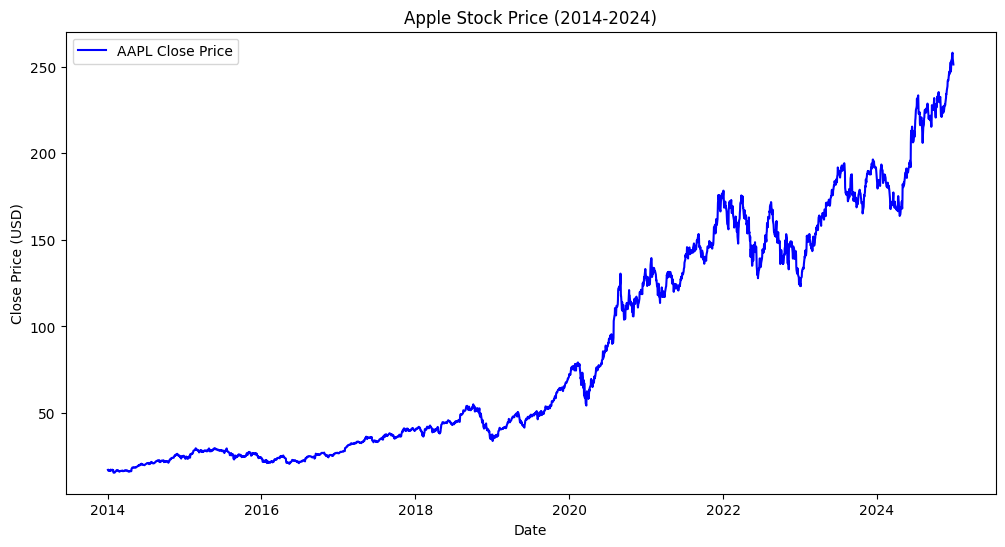

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price', color='blue')
plt.title('Apple Stock Price (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


# Exploratory Data Analysis (EDA)

# Trend Analysis: Plotted closing prices over time (avg closing price over time).

C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_24732\2088385048.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = data['Close'].resample('Y').mean()


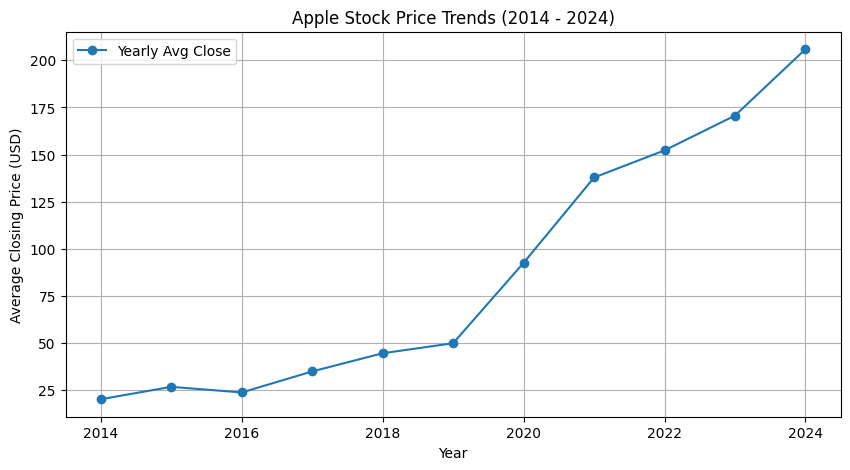

In [7]:
# Resample data to yearly average (using Closing Price)
yearly_avg = data['Close'].resample('Y').mean()

# Convert index to year only
yearly_avg.index = yearly_avg.index.year

# Plot yearly average closing price trends
plt.figure(figsize=(10,5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-', label="Yearly Avg Close")
plt.title("Apple Stock Price Trends (2014 - 2024)")
plt.xlabel("Year")
plt.ylabel("Average Closing Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

# Moving Averages: 50-day and 200-day moving averages to spot trend crossovers.

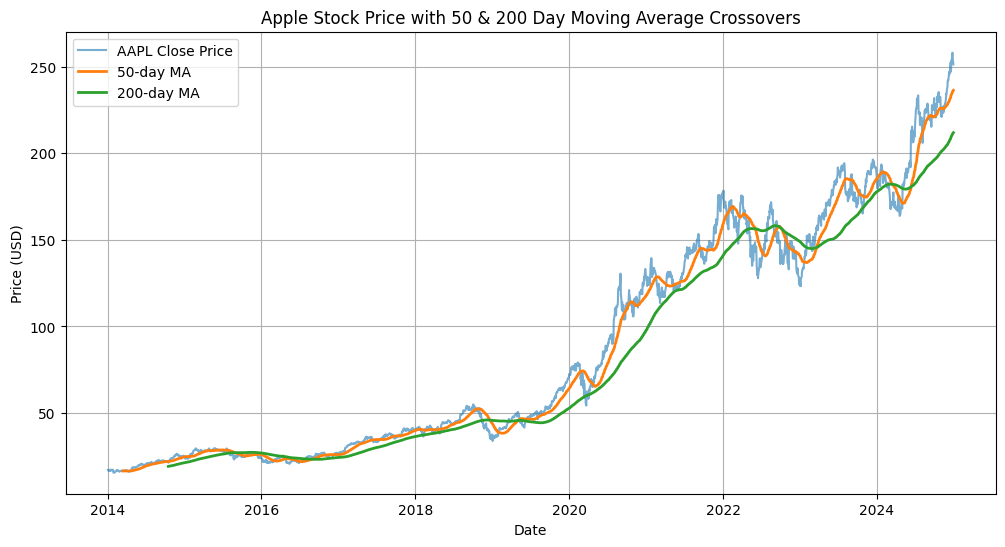

In [8]:
# Calculate Moving Averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price', alpha=0.6)
plt.plot(data['MA50'], label='50-day MA', linewidth=2)
plt.plot(data['MA200'], label='200-day MA', linewidth=2)

plt.title("Apple Stock Price with 50 & 200 Day Moving Average Crossovers")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Daily Returns: Calculated percent change and visualized distribution of returns using histograms.

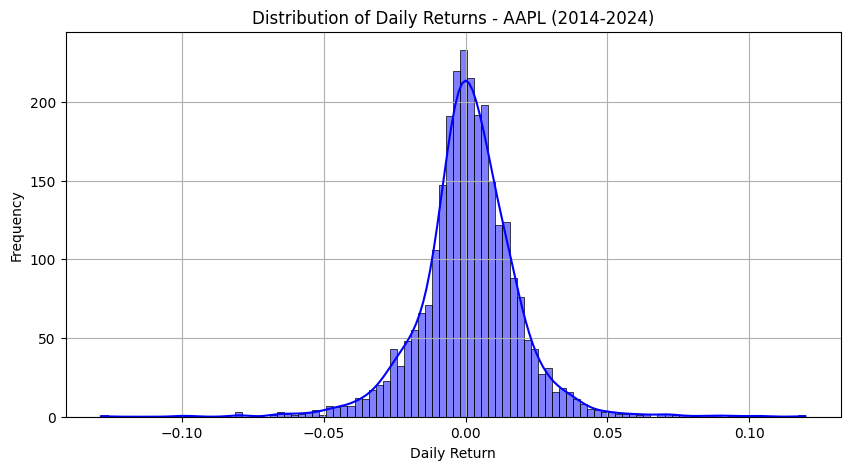

In [9]:
# Compute daily returns
data['Daily_Return'] = data['Close'].pct_change()

# Plot histogram of returns
plt.figure(figsize=(10,5))
sns.histplot(data['Daily_Return'].dropna(), bins=100, kde=True, color="blue")
plt.title("Distribution of Daily Returns - AAPL (2014-2024)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
# 1. Check missing values
print(data.isna().sum())

Price         Ticker
Close         AAPL        0
High          AAPL        0
Low           AAPL        0
Open          AAPL        0
Volume        AAPL        0
MA50                     49
MA200                   199
Daily_Return              1
dtype: int64


# Data Preprocessing

# Selected ‘Close’ price for modeling.

# Normalized data using MinMaxScaler to scale values between 0 and 1 (important for LSTM performance).

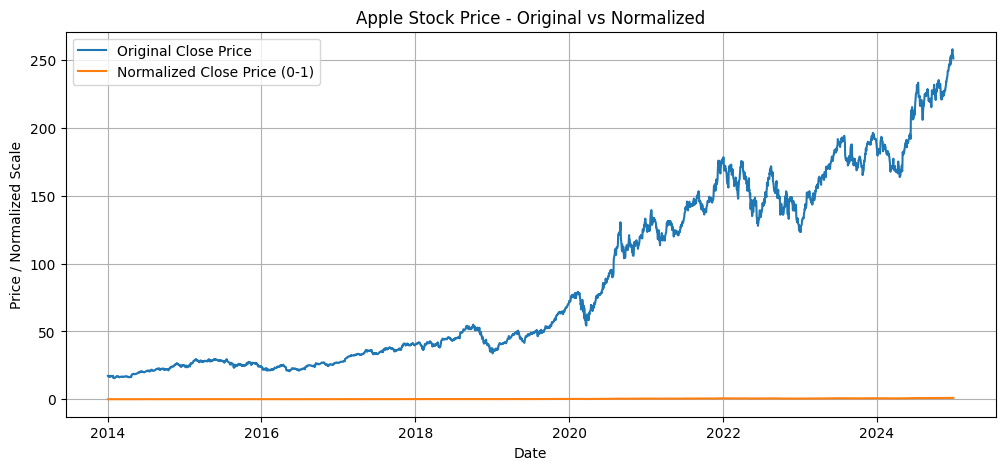

In [11]:
# Select the Close price
close_prices = data[['Close']]

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform
normalized_prices = scaler.fit_transform(close_prices)

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_prices, index=close_prices.index, columns=['Normalized_Close'])

# Plot original vs normalized
plt.figure(figsize=(12,5))
plt.plot(close_prices.index, close_prices['Close'], label="Original Close Price")
plt.plot(normalized_df.index, normalized_df['Normalized_Close'], label="Normalized Close Price (0-1)")
plt.title("Apple Stock Price - Original vs Normalized")
plt.xlabel("Date")
plt.ylabel("Price / Normalized Scale")
plt.legend()
plt.grid(True)
plt.show()

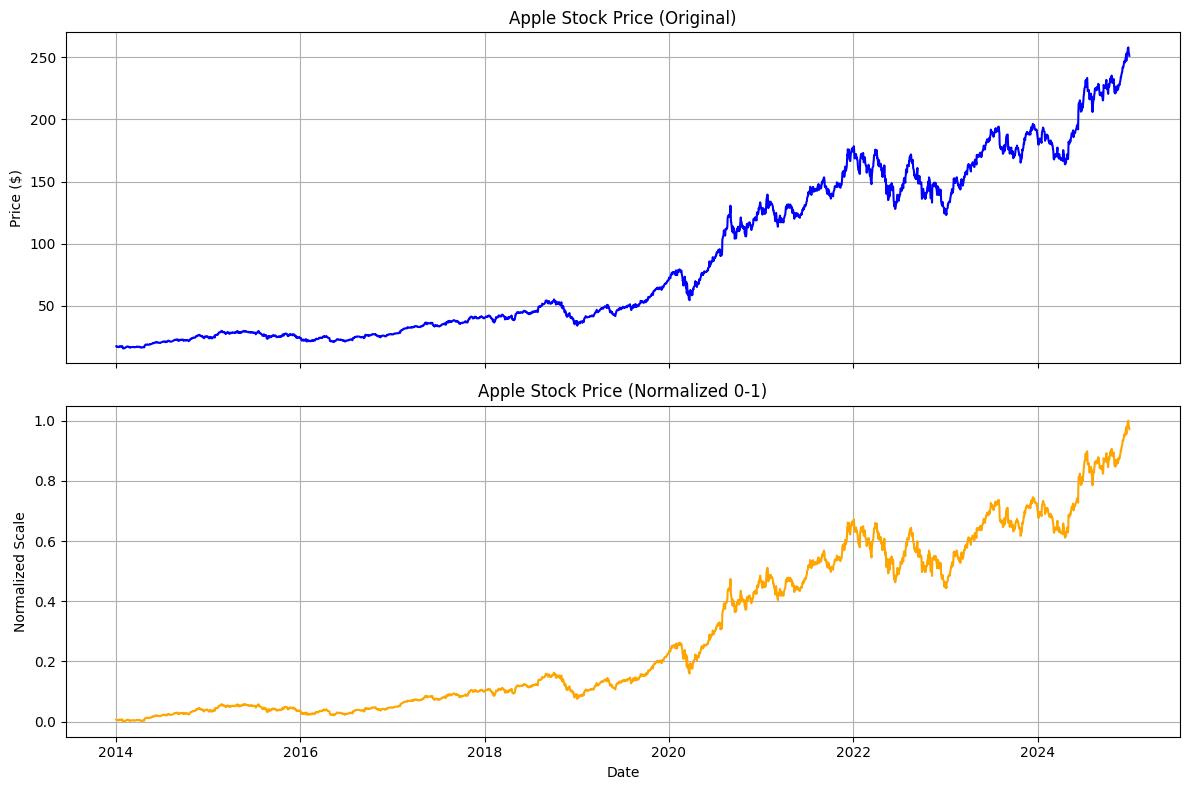

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Original prices
ax[0].plot(close_prices.index, close_prices['Close'], label="Original Close Price", color="blue")
ax[0].set_title("Apple Stock Price (Original)")
ax[0].set_ylabel("Price ($)")
ax[0].grid(True)

# Normalized prices
ax[1].plot(normalized_df.index, normalized_df['Normalized_Close'], label="Normalized Close Price (0-1)", color="orange")
ax[1].set_title("Apple Stock Price (Normalized 0-1)")
ax[1].set_ylabel("Normalized Scale")
ax[1].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# 

In [13]:
import pandas as pd

# Previous day's closing price (lag feature)
data['Prev_Close'] = data['Close'].shift(1)

# 7-day moving average
data['7d_MA'] = data['Close'].rolling(window=7).mean()

# Drop rows with NaN caused by shifting/rolling (optional)
data = data.dropna()

# Display sample
print(data[['Close', 'Prev_Close', '7d_MA']].head(10))


Price           Close Prev_Close      7d_MA
Ticker           AAPL                      
Date                                       
2014-10-16  21.268505  21.551317  21.934190
2014-10-17  21.580044  21.268505  21.835395
2014-10-20  22.041822  21.580044  21.795625
2014-10-21  22.640593  22.041822  21.850546
2014-10-22  22.755486  22.640593  21.950920
2014-10-23  23.162031  22.755486  22.142828
2014-10-24  23.248201  23.162031  22.385240
2014-10-27  23.223896  23.248201  22.664582
2014-10-28  23.584051  23.223896  22.950869
2014-10-29  23.716612  23.584051  23.190124


In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# 2. Function to create sequences
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])   # 60 values as input
        y.append(dataset[i + time_step, 0])       # 1 value as output
    return np.array(X), np.array(y)

# 3. Create sequences
time_step = 60
X, y = create_sequences(scaled_data, time_step)

# 4. Reshape for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 5. Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (2006, 60, 1)
y_train shape: (2006,)


# Building the LSTM Model

# Built stacked LSTM network with Dropout layers to reduce overfitting.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(60))
model.add(Dense(1))  # predicting Close price

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\FAUZAN\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,981 (171.80 KB)

 Trainable params: 43,981 (171.80 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, verbose=1)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0047 - val_loss: 6.8770e-04
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6910e-04 - val_loss: 9.9889e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5372e-04 - val_loss: 0.0012
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4613e-04 - val_loss: 0.0011
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.3515e-04 - val_loss: 0.0023
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2956e-04 - val_loss: 9.4095e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1118e-04 - val_loss: 8.4431e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0959e-04 - val_loss: 8.6856e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5265e-04 - val_loss: 7.8811e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0028e-04 - val_loss: 0.0011
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7284e-04 - val_loss: 8.2384

# Model Evaluation

# Predicted on train and test sets

# Inverse transformed back to original price scale for meaningful interpretation.

# Calculated metrics:

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train RMSE: 3.315008339058205
Test RMSE: 4.54074253794624
Train MAE: 2.0708983831129903
Test MAE: 3.529424127829502


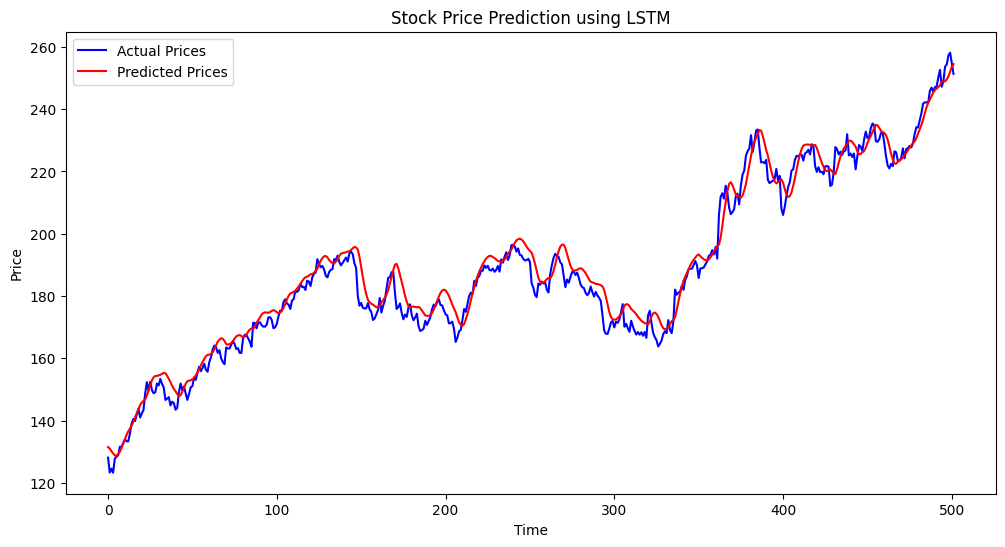

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(test_predict, label="Predicted Prices", color='red')
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


# Future Forecasting (Next 30 Days)

# Used rolling prediction starting from the last 60-day sequence:

            Predicted_Close
Date                       
2024-12-31       254.426422
2025-01-01       254.674561
2025-01-02       254.593460
2025-01-03       254.295334
2025-01-06       253.849472
2025-01-07       253.300797
2025-01-08       252.680420
2025-01-09       252.011520
2025-01-10       251.312271
2025-01-13       250.598358


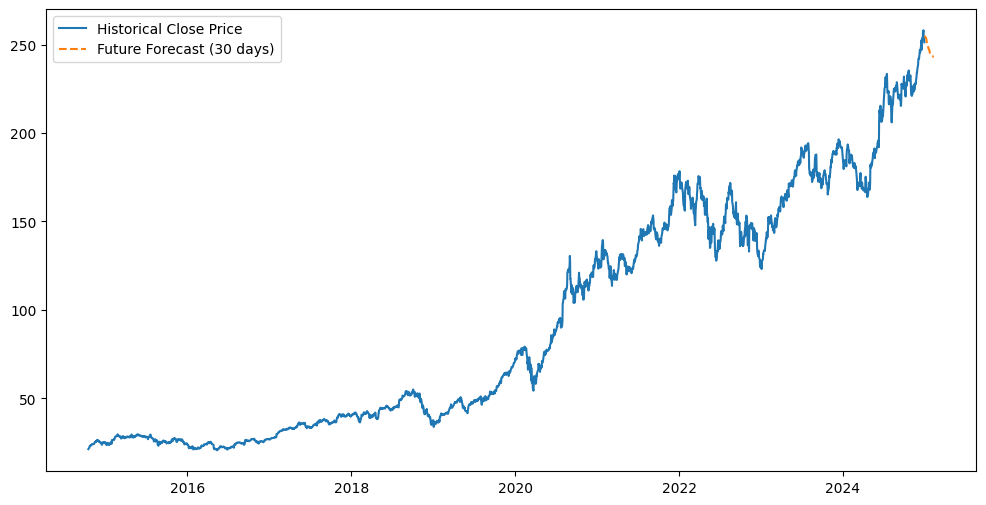

In [18]:
import numpy as np

# Number of days to forecast
future_days = 30  

# Start with the last available data (last sequence used for prediction)
last_sequence = X_test[-1]   # shape (lookback, 1)
future_predictions = []

for _ in range(future_days):
    # Reshape to (1, lookback, 1) for LSTM
    current_input = last_sequence.reshape(1, last_sequence.shape[0], 1)
    
    # Predict next value
    next_pred = model.predict(current_input, verbose=0)
    
    # Save the prediction
    future_predictions.append(next_pred[0,0])
    
    # Update last_sequence: drop first value, append the predicted one
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(-1, 1)

# Inverse transform back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days+1, freq="B")[1:]  # B = business days

# Put into dataframe
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
forecast_df.set_index("Date", inplace=True)

print(forecast_df.head(10))  # show first 10 predicted days

# Plot actual vs predictions
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label="Historical Close Price")
plt.plot(forecast_df['Predicted_Close'], label="Future Forecast (30 days)", linestyle="dashed")
plt.legend()
plt.show()


# Hyperparameter Tuning

In [19]:
from keras.optimizers import Adam
from keras.layers import Dropout

def build_model(units=60, lr=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# Example: try different hyperparameters
param_grid = [
    {"units": 50, "lr": 0.001, "dropout_rate": 0.2},
    {"units": 100, "lr": 0.0005, "dropout_rate": 0.3},
    {"units": 60, "lr": 0.001, "dropout_rate": 0.1}
]

for params in param_grid:
    model = build_model(**params)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                        validation_split=0.1, verbose=1)
    val_loss = min(history.history['val_loss'])
    print(f"Params: {params}, Best Val Loss: {val_loss}")


Epoch 1/10


c:\Users\FAUZAN\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1717e-04 - val_loss: 0.0012
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.5500e-04 - val_loss: 9.6178e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.0267e-04 - val_loss: 8.8076e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4842e-04 - val_loss: 8.7246e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.2597e-04 - val_loss: 0.0020
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.8626e-04 - val_loss: 9.8653e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.5821e-04 - val_loss: 8.0329e-04
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.1006e-04 - val_loss: 0.0010
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3447e-04 - val_loss: 7.2960e-04
Params: {'units': 50, 'lr': 0.001, 'dropout_rate': 0.2}, Best Val Loss: 0.0007296004332602024
Epoch 

# After testing multiple hyperparameter combinations (different LSTM units, learning rates, and dropout rates), I selected the best performing configuration based on the lowest validation loss.

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ------------------------ Build final model with best params ------------------------
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # 50 units
model.add(Dropout(0.2))  # 0.2 dropout
model.add(LSTM(50))      # 50 units
model.add(Dropout(0.2))  # 0.2 dropout
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)  # learning rate 0.001
model.compile(optimizer=optimizer, loss='mse')

# ------------------------ Train on full training data ------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ------------------------ Evaluate model ------------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)


Epoch 1/50


c:\Users\FAUZAN\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0091 - val_loss: 8.1843e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.8566e-04 - val_loss: 7.8052e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.5391e-04 - val_loss: 6.9798e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.1461e-04 - val_loss: 0.0021
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.9460e-04 - val_loss: 0.0027
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.5488e-04 - val_loss: 0.0048
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9557e-04 - val_loss: 0.0012
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.0245e-04 - val_loss: 6.8212e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.2520e-04 - val_loss: 0.0034
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.0272e-04 - val_loss: 0.0049
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7442e-04 - val_loss: 0.0012
Epoch 12/50
63/63 

# Forecast Next 30 Days

# Using the trained final model, I performed rolling multi-step forecasting to predict the stock price for the next 30 business days.

In [24]:
# ------------------------ Future 30-day forecasting ------------------------
future_days = 30
last_sequence = X_test[-1]  # last sequence from test set
future_predictions = []

for _ in range(future_days):
    current_input = last_sequence.reshape(1, last_sequence.shape[0], 1)
    next_pred = model.predict(current_input, verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(-1, 1)

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days+1, freq="B")[1:]

# Create DataFrame for forecast
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
forecast_df.set_index('Date', inplace=True)
print(forecast_df.head(10))

            Predicted_Close
Date                       
2024-12-31       245.518250
2025-01-01       244.078888
2025-01-02       241.749954
2025-01-03       238.999573
2025-01-06       236.092667
2025-01-07       233.172241
2025-01-08       230.312607
2025-01-09       227.550278
2025-01-10       224.900543
2025-01-13       222.367783


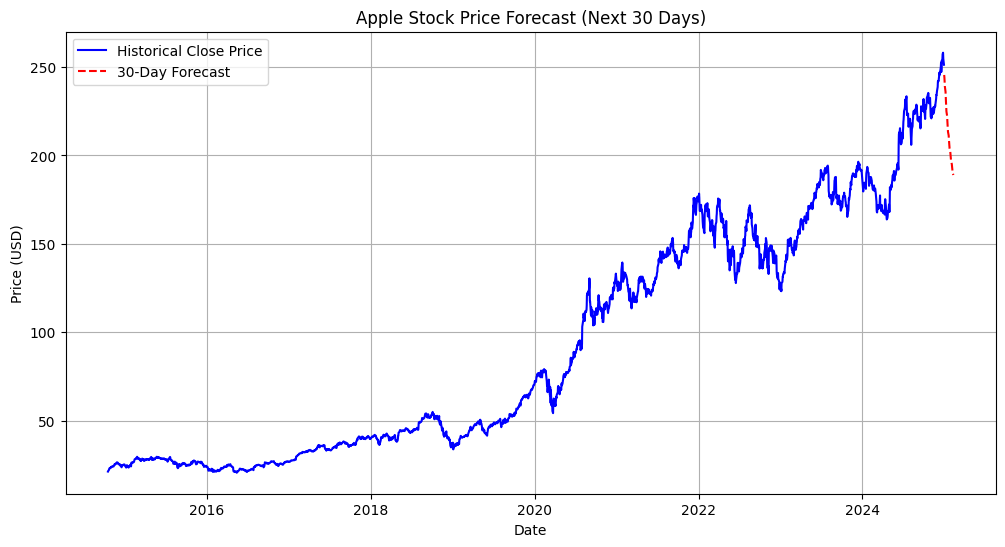

In [25]:
# ------------------------ Plot historical + forecast ------------------------
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label="Historical Close Price", color='blue')
plt.plot(forecast_df['Predicted_Close'], label="30-Day Forecast", linestyle='dashed', color='red')
plt.title("Apple Stock Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()